In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [ ]:
import sys
import subprocess

#do not run this thing

def install_package(package, extra_index_urls=[]):
    cmd = [sys.executable, "-m", "pip", "install", package]
    for url in extra_index_urls:
        cmd.extend(["--extra-index-url", url])
    try:
        subprocess.run(cmd, check=True)
        print(f"Installation of {package} successful.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while installing the package {package}: {e}")

INSTALL = True  # Set to True to install dependencies

if INSTALL:
    # Install cuml-cu11 from NVIDIA's repository
    install_package("cuml-cu11", ["https://pypi.nvidia.com"])
    
    # Install dinov2 from GitHub repository using PEP 508 compatible syntax
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    install_package(f"dinov2[extras] @ git+{REPO_URL}", 
                    ["https://download.pytorch.org/whl/cu117", "https://pypi.nvidia.com"])

In [1]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

In [2]:
#load the pretrained backbone

BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /local/home/ekoller/.cache/torch/hub/facebookresearch_dinov2_main
/local/home/ekoller/tmp_repo/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/local/home/ekoller/tmp_repo/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/local/home/ekoller/tmp_repo/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [4]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 3 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.cuda()
model.eval()

2024-07-29 17:55:20,991 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2024-07-29 17:55:20,993 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([21, 1536, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-07-29 17:55:20,993 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([21]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-07-29 17:55:20,994 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2024-07-29 17:55:20,994 - mmcv - INFO - 
decode_head.bn.bias - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 


scales: [1.0, 1.32, 1.73]
load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_voc2012_ms_head.pth


EncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(1536, 21, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

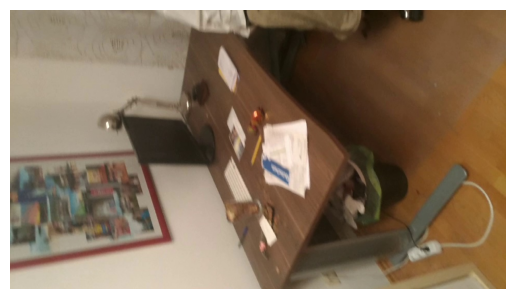

In [5]:
import urllib
import os.path as osp
import cv2
from PIL import Image
import matplotlib.pyplot as plt



frame_number = "000008"
scan_id = "38770c95-86d7-27b8-8717-3485b411ddc7"
EXAMPLE_IMAGE = osp.join("/local/home/ekoller/R3Scan/scenes", scan_id, "sequence/frame-{}.color.jpg".format(frame_number))

image_bgr = cv2.imread(EXAMPLE_IMAGE)

image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

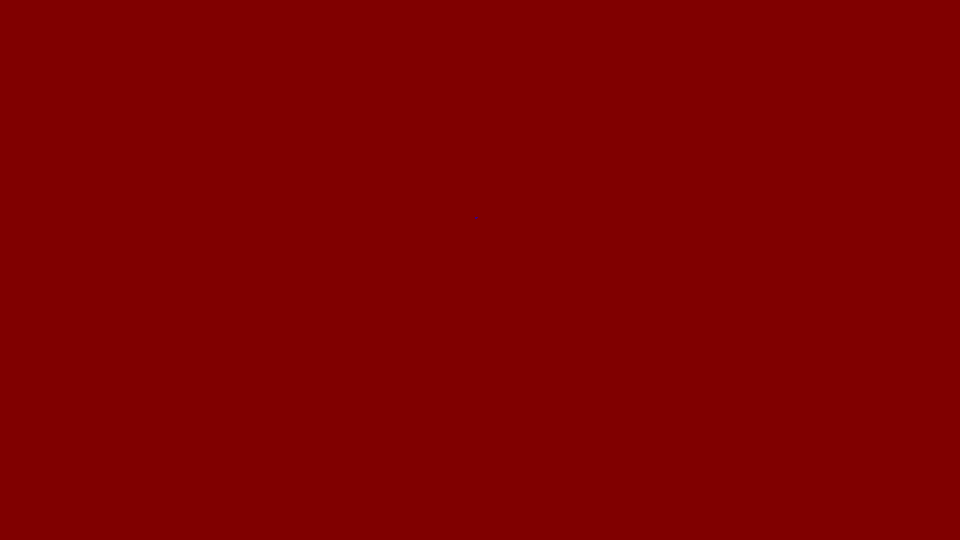

In [6]:
import numpy as np

import dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)


array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

In [ ]:
here the fun starts!!!!!!!!!!!!!!!!!¨¨

In [1]:
import dinov2.eval.segmentation_m2f.models.segmentors 
import mmcv
from mmcv.runner import load_checkpoint
import math
import itertools
from functools import partial
import urllib

import torch
import torch.nn.functional as F
import mmseg
from mmseg.apis import init_segmentor, inference_segmentor
# Check PyTorch CUDA availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(torch.__version__)
# Print CUDA and cuDNN version
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")

print("mmsec version", mmseg.__version__)

import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))



PyTorch CUDA available: True
2.0.0+cu117
CUDA version: 11.7
cuDNN version: 8500
mmsec version 0.27.0
PyTorch version: 2.0.0+cu117
CUDA version: 11.7
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 2080
Tensor on GPU: tensor([[0.3797, 0.9814, 0.3905, 0.2082, 0.5397],
        [0.8692, 0.6423, 0.4976, 0.6254, 0.5833],
        [0.2852, 0.4162, 0.7568, 0.4242, 0.1261],
        [0.2501, 0.1279, 0.8199, 0.0528, 0.0272],
        [0.5328, 0.0801, 0.4891, 0.2822, 0.5262]], device='cuda:0')


In [2]:



def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()
    
DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
CONFIG_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f_config.py"
CHECKPOINT_URL = f"{DINOV2_BASE_URL}/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth"

cfg_str = load_config_from_url(CONFIG_URL)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = init_segmentor(cfg)
load_checkpoint(model, CHECKPOINT_URL, map_location="cpu")
model.cuda()
model.eval()

/local/home/ekoller/tmp_repo/dinov2/dinov2/eval/segmentation_m2f/models/losses/cross_entropy_loss.py:222: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/local/home/ekoller/anaconda3/envs/new_dino_seg/lib/python3.9/site-packages/mmcv/ops/multi_scale_deform_attn.py:216: UserWarning: You'd better set embed_dims in MultiScaleDeformAttention to make the dimension of each attention head a power of 2 which is more efficient in our CUDA implementation.
  warnings.warn(


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_ade20k_m2f.pth


EncoderDecoderMask2Former(
  (backbone): ViTAdapter(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFN(
          (w1): Linear(in_features=1536, out_features=4096, bias=True)
          (w2): Linear(in_features=1536, out_features=4096, bias=True)
          (w3): Linear(in_features=4096, out_features=1536, bias=True)
        )
      )
     

: 

In [3]:
torch.cuda.empty_cache()

: 

In [9]:
import numpy as np
import PIL as Image
import os.path as osp
import cv2

torch.cuda.empty_cache()


frame_number = "000008"
scan_id = "38770c95-86d7-27b8-8717-3485b411ddc7"
EXAMPLE_IMAGE = osp.join("/local/home/ekoller/R3Scan/scenes", scan_id, "sequence/frame-{}.color.jpg".format(frame_number))

image_bgr = cv2.imread(EXAMPLE_IMAGE)

image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
array = np.array(image)[:, :, ::-1] # BGR
#less momry
with torch.no_grad():
    with torch.cuda.amp.autocast():
        segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, "ade20k")
display(segmented_image)

OutOfMemoryError: CUDA out of memory. Tried to allocate 272.00 MiB (GPU 0; 7.80 GiB total capacity; 6.56 GiB already allocated; 97.00 MiB free; 6.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 